In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/aslr_model.hdf5'
tflite_save_path = 'model/aslr_model.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
26/36 [====================>.........] - ETA: 0s - loss: 3.1682 - accuracy: 0.0526 
Epoch 1: saving model to model\aslr_model.hdf5
36/36 [==============================] - 1s 15ms/step - loss: 3.1530 - accuracy: 0.0577 - val_loss: 3.0783 - val_accuracy: 0.0954
Epoch 2/1000
30/36 [========================>.....] - ETA: 0s - loss: 3.0567 - accuracy: 0.0859
Epoch 2: saving model to model\aslr_model.hdf5
36/36 [==============================] - 0s 7ms/step - loss: 3.0449 - accuracy: 0.0880 - val_loss: 2.9628 - val_accuracy: 0.1234
Epoch 3/1000
19/36 [==============>...............] - ETA: 0s - loss: 2.9379 - accuracy: 0.1110
Epoch 3: saving model to model\aslr_model.hdf5
36/36 [==============================] - 0s 5ms/step - loss: 2.9159 - accuracy: 0.1189 - val_loss: 2.8222 - val_accuracy: 0.1803
Epoch 4/1000
23/36 [==================>...........] - ETA: 0s - loss: 2.8098 - accuracy: 0.1447
Epoch 4: saving model to model\aslr_model.hdf5
36/36 [==============================] 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 2ms/step - loss: 0.3906 - accuracy: 0.9236


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 121ms/step
[3.64374882e-03 9.93064139e-04 2.33560540e-02 7.55066594e-07
 6.20914022e-08 1.77557231e-04 1.58515140e-05 3.43972002e-04
 9.58862185e-01 1.74414101e-23 1.09096365e-02 7.80683268e-16
 1.22269894e-15 1.24745502e-03 3.19404023e-08 1.96227035e-08
 2.22998594e-12 8.41422789e-08 2.02085082e-09 6.17006454e-15
 4.20920481e-24 3.47274493e-22 1.75768000e-04 2.73709040e-04]
8


# Confusion matrix

48/48 [==============================] - 0s 1ms/step


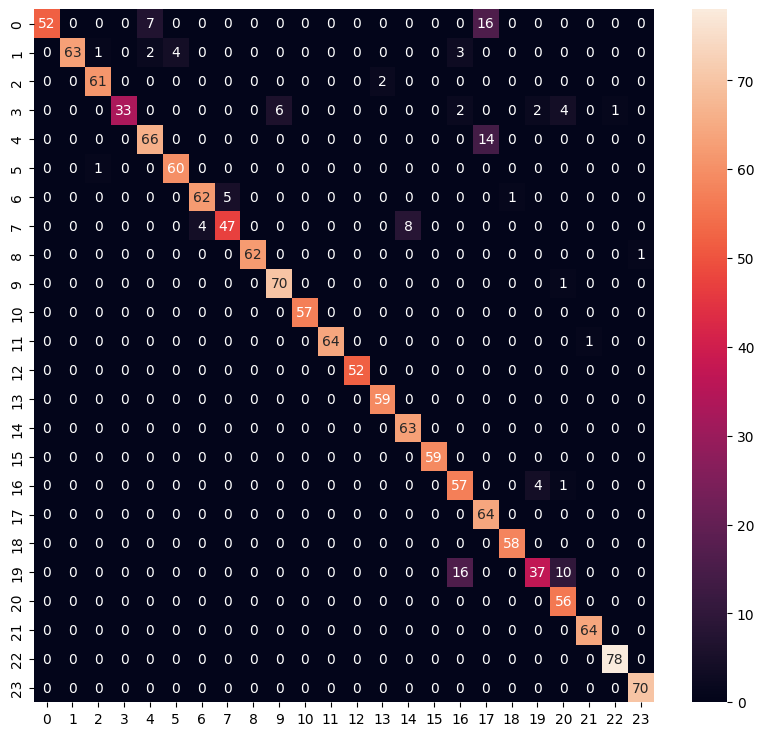

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.69      0.82        75
           1       1.00      0.86      0.93        73
           2       0.97      0.97      0.97        63
           3       1.00      0.69      0.81        48
           4       0.88      0.82      0.85        80
           5       0.94      0.98      0.96        61
           6       0.94      0.91      0.93        68
           7       0.90      0.80      0.85        59
           8       1.00      0.98      0.99        63
           9       0.92      0.99      0.95        71
          10       1.00      1.00      1.00        57
          11       1.00      0.98      0.99        65
          12       1.00      1.00      1.00        52
          13       0.97      1.00      0.98        59
          14       0.89      1.00      0.94        63
          15       1.00      1.00      1.00        59
          16       0.73      0.92      0.81        62
     

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 9))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpa83t6gi4\assets


INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmpa83t6gi4\assets


7424

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.6437504e-03 9.9306321e-04 2.3356063e-02 7.5506580e-07 6.2091516e-08
 1.7755690e-04 1.5851467e-05 3.4397171e-04 9.5886219e-01 1.7441412e-23
 1.0909626e-02 7.8068618e-16 1.2226990e-15 1.2474569e-03 3.1940335e-08
 1.9622703e-08 2.2299820e-12 8.4142130e-08 2.0208428e-09 6.1700641e-15
 4.2091729e-24 3.4727447e-22 1.7576800e-04 2.7370901e-04]
8
